### Import packages and define variables

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from math import log, tan, atan, pi

In [2]:
coronal_samples = ['SpinalCord','Well01brain','Well01OB','Well1_5',
                   'Well2_5','Well03','Well3_5','Well04','Well05','Well06','Well07','Well7_5',
                    'Well08','Well09','Well10','Well10_5','Well11'
]
         

sagittal_samples = ['Sagittal1','Sagittal2','Sagittal3']

geneid = 1 # we use gene 1 for each sagittal sample

In [3]:
non_ctype = "Unannotated"
plt.rcParams.update({'font.size': 16, 'svg.fonttype': 'none'})

In [4]:
def lowercase(sample):
    if sample == "Well01OB":
        return "well01OB"
    return sample.lower()

### Load data (example for Rank 5 label but others are similar)

In [7]:
import scanpy as sc
ad_1008 = sc.read_h5ad('J:\\ClusterMap2\\ccf\\Revision_0914\\adata_final_1008.h5ad')

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
tissue = ad_1008.obs

In [10]:
tissue = tissue[tissue['sample'].isin([lowercase(sample) for sample in coronal_samples + sagittal_samples])].reset_index(drop=True)

In [11]:
group_key = 'Rank4_Refine' # Rank4_Refine or Rank5_Symbol or Tissue_symbol

if group_key == 'Rank4_Refine':
    fs = (20, 20)
    ct_label = "Rank 4 Cell Type (#1 of Cells)"
    title = "racRNA uptake by cell type "
elif group_key == 'Rank5_Symbol':
    fs = (20, 90)
    ct_label = "Rank 5 Cell Type (# of Cells)"
    title = "racRNA uptake by cell type "
else:
    fs = (20, 60)
    ct_label = "Tissue region (# of Cells)"
    title = "racRNA uptake by tissue type "

In [12]:
colors = pd.read_csv('color_final.csv').query('subset == @group_key').reset_index().sort_values(by='sortkey')

In [13]:
data = {}

for coronal in coronal_samples:
    current = {}
    temp = pd.read_csv(f'output/cell_info_dapi/{coronal}_info_by_cell.csv')
    temp = temp[['cellid_idx', 'racRNA uptake']]
    for _, row in temp.iterrows():
        current[int(row['cellid_idx'])] = int(row['racRNA uptake'])
    data[lowercase(coronal)] = current
    
    print(f"finished processing data for {coronal}")

for sagittal in sagittal_samples:
    current = {}
    temp = pd.read_csv(f'output/cell_info_dapi/{sagittal}_info_by_cell.csv')
    temp = temp[['cellid_idx', 'racRNA uptake', 'geneid']]
    for _, row in temp.iterrows():
        if row['geneid'] == geneid:
            current[int(row['cellid_idx'])] = int(row['racRNA uptake'])
    data[lowercase(sagittal)] = current
    
    print(f"finished processing data for {sagittal}")

finished processing data for SpinalCord
finished processing data for Well01brain
finished processing data for Well01OB
finished processing data for Well1_5
finished processing data for Well2_5
finished processing data for Well03
finished processing data for Well3_5
finished processing data for Well04
finished processing data for Well05
finished processing data for Well06
finished processing data for Well07
finished processing data for Well7_5
finished processing data for Well08
finished processing data for Well09
finished processing data for Well10
finished processing data for Well10_5
finished processing data for Well11
finished processing data for Sagittal1
finished processing data for Sagittal2
finished processing data for Sagittal3


In [14]:
tissue['racRNA count'] = tissue.apply(
    lambda row : data.get(row['sample'], {}).get(row['orginindex'], 0), axis=1
)

In [15]:
coronals = tissue.query('sample != "sagittal1" and sample != "sagittal2" and sample != "sagittal3"').reset_index()
sagittals = tissue.query('sample == "sagittal1" or sample == "sagittal2" or sample == "sagittal3"').reset_index()

In [16]:
relevant_colors = list(colors['color'])
cp = sns.set_palette(relevant_colors)

In [17]:
sortkey_dict = {}

for _, row in colors.iterrows():
    sortkey_dict[row['label']] = row['sortkey']

### Compute coronal data

In [18]:
ct_data = {}

for _, row in coronals.iterrows():
    if row[group_key] not in ct_data.keys():
        ct_data[row[group_key]] = []
    ct_data[row[group_key]].append(row['racRNA count'])

In [19]:
to_df_coronal = {
    group_key: [],
    'count': [],
    'min': [],
    'max': [],
    'mean': [],
    'median': [],
    'std dev': [],
    'left whisker (2.5th percentile)': [],
    'right whisker (97.5th percentile)': [],
    '25th percentile': [],
    '75th percentile': []
}

In [20]:
for key, val in ct_data.items():
    to_df_coronal[group_key].append(key)
    to_df_coronal['count'].append(float(len(val)))
    to_df_coronal['min'].append(float(np.min(val)))
    to_df_coronal['max'].append(float(np.max(val)))
    to_df_coronal['mean'].append(np.mean(val))
    to_df_coronal['median'].append(np.median(val))
    to_df_coronal['std dev'].append(np.std(val, ddof=1))
    to_df_coronal['left whisker (2.5th percentile)'].append(np.quantile(val, .025))
    to_df_coronal['right whisker (97.5th percentile)'].append(np.quantile(val, .975))
    to_df_coronal['25th percentile'].append(np.quantile(val, 0.25))
    to_df_coronal['75th percentile'].append(np.quantile(val, 0.75))

In [21]:
df_coronal = pd.DataFrame(to_df_coronal)
df_coronal['iqr'] = df_coronal['75th percentile'] - df_coronal['25th percentile']
df_coronal = df_coronal.sort_values(by=group_key, key=(lambda col : [sortkey_dict[str(name)] for name in col])).reset_index().drop('index', axis=1)

In [22]:
df_coronal.to_csv('coronal_dapi_figure_data.csv')

In [102]:
df_coronal=pd.read_csv('coronal_dapi_figure_data.csv',index_col=0)

### Plot coronal data

In [60]:
df_coronal1=df_coronal.copy()

In [62]:
low = {}
left_box = {}
median = {}
right_box = {}
high = {}
label = {}

for _, row in df_coronal.iterrows():
    low[row[group_key]] = row['left whisker (2.5th percentile)']
    left_box[row[group_key]] = row['25th percentile']
    median[row[group_key]] = row['median']
    right_box[row[group_key]] = row['75th percentile']
    high[row[group_key]] = row['right whisker (97.5th percentile)']
    label[row[group_key]] = row[group_key] + f" ({int(row['count'])})"
    
to_plot_df = {
    'y': [],
    'x': []
}

for _, row in colors.iterrows():
    current_type = row['label']
    for t in range(5):
        to_plot_df['y'].append(label.get(current_type, current_type + " (0)"))
    to_plot_df['x'].append(low.get(current_type, -100))
    to_plot_df['x'].append(left_box.get(current_type, -100))
    to_plot_df['x'].append(median.get(current_type, -100))
    to_plot_df['x'].append(right_box.get(current_type, -100))
    to_plot_df['x'].append(high.get(current_type, -100))

plot_df = pd.DataFrame(to_plot_df)
plot_df['xlog'] = plot_df.apply(
    lambda row : log(1 + row['x']) if row['x'] >= 0 else -100, axis=1
)

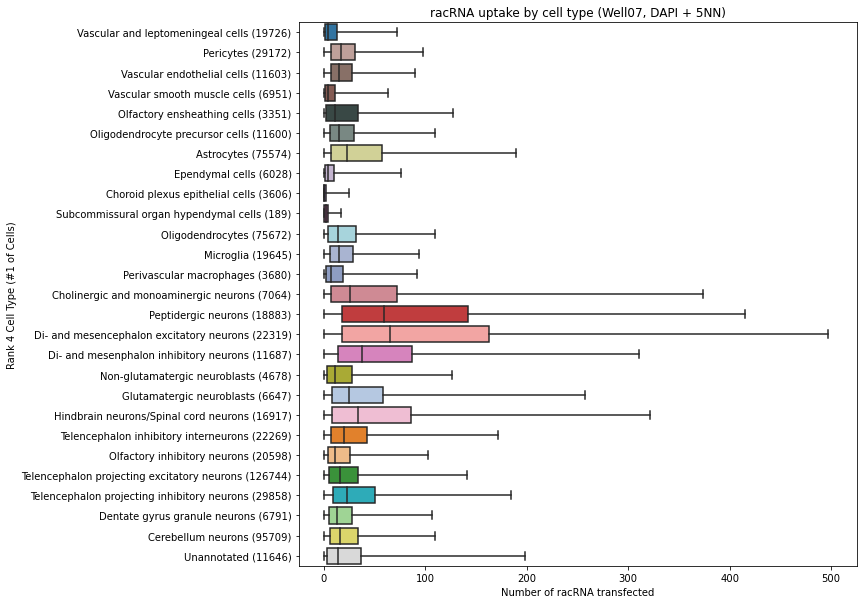

In [63]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(y='y', x='x', data=plot_df, showfliers=True, orient='h', palette=cp, whis=100)
if group_key == 'Rank5_Symbol':
    xtick_base = [0, 200, 400, 600, 800, 1000, 1200]
else:
    xtick_base = [0, 100, 200, 300, 400, 500]
xticks = xtick_base
ax.set(xticks=xticks)
ax.set(xticklabels=[str(i) for i in xtick_base])
plt.title(title + "(Well07, DAPI + 5NN)")
plt.xlim(left=-25, right=25 + xtick_base[-1])
plt.ylabel(ct_label)
plt.xlabel("Number of racRNA transfected")
plt.savefig(f"plot//coronal_Rank4_Refine.png", bbox_inches="tight",dpi=300)

### Compute sagittal data

In [84]:
st_data = {}

for _, row in sagittals.iterrows():
    if row[group_key] not in st_data.keys():
        st_data[row[group_key]] = []
    st_data[row[group_key]].append(row['racRNA count'])

In [85]:
to_df_sagittal = {
    group_key: [],
    'count': [],
    'min': [],
    'max': [],
    'mean': [],
    'median': [],
    'std dev': [],
    'left whisker (2.5th percentile)': [],
    'right whisker (97.5th percentile)': [],
    '25th percentile': [],
    '75th percentile': []
}

In [86]:
for key, val in st_data.items():
    to_df_sagittal[group_key].append(key)
    to_df_sagittal['count'].append(float(len(val)))
    to_df_sagittal['min'].append(float(np.min(val)))
    to_df_sagittal['max'].append(float(np.max(val)))
    to_df_sagittal['mean'].append(np.mean(val))
    to_df_sagittal['median'].append(np.median(val))
    if len(val) > 1:
        to_df_sagittal['std dev'].append(np.std(val, ddof=1))
    else:
        to_df_sagittal['std dev'].append(0.0)
    to_df_sagittal['left whisker (2.5th percentile)'].append(np.quantile(val, .025))
    to_df_sagittal['right whisker (97.5th percentile)'].append(np.quantile(val, .975))
    to_df_sagittal['25th percentile'].append(np.quantile(val, 0.25))
    to_df_sagittal['75th percentile'].append(np.quantile(val, 0.75))
    
df_sagittal = pd.DataFrame(to_df_sagittal)
df_sagittal['iqr'] = df_sagittal['75th percentile'] - df_sagittal['25th percentile']
df_sagittal = df_sagittal.sort_values(by=group_key, key=(lambda col : [sortkey_dict[str(name)] for name in col])).reset_index().drop('index', axis=1)

In [87]:
df_sagittal.to_csv('sagittal_dapi_figure_data.csv')

In [88]:
low = {}
left_box = {}
median = {}
right_box = {}
high = {}
label = {}

for _, row in df_sagittal.iterrows():
    low[row[group_key]] = row['left whisker (2.5th percentile)']
    left_box[row[group_key]] = row['25th percentile']
    median[row[group_key]] = row['median']
    right_box[row[group_key]] = row['75th percentile']
    high[row[group_key]] = row['right whisker (97.5th percentile)']
    label[row[group_key]] = row[group_key] + f" ({int(row['count'])})"
    
to_plot_df = {
    'y': [],
    'x': []
}

for _, row in colors.iterrows():
    current_type = row['label']
    for t in range(5):
        to_plot_df['y'].append(label.get(current_type, current_type + " (0)"))
    to_plot_df['x'].append(low.get(current_type, -100))
    to_plot_df['x'].append(left_box.get(current_type, -100))
    to_plot_df['x'].append(median.get(current_type, -100))
    to_plot_df['x'].append(right_box.get(current_type, -100))
    to_plot_df['x'].append(high.get(current_type, -100))

plot_df = pd.DataFrame(to_plot_df)
plot_df['xlog'] = plot_df.apply(
    lambda row : log(1 + row['x']) if row['x'] >= 0 else -100, axis=1
)

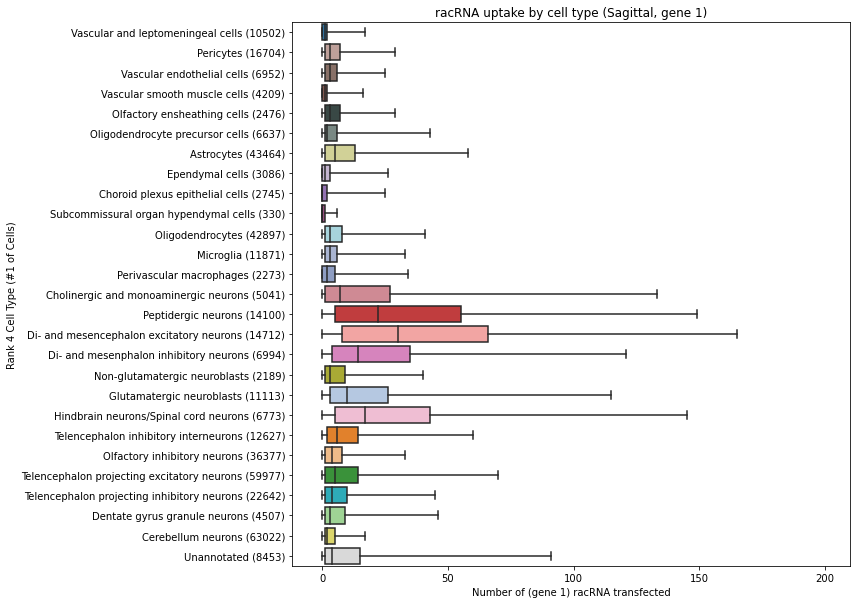

In [59]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(y='y', x='x', data=plot_df, showfliers=True, orient='h', palette=cp, whis=100)
if group_key == 'Rank5_Symbol':
    xtick_base = [0, 50, 100, 150, 200, 250]
else:
    xtick_base = [0, 50, 100, 150, 200]
xticks = xtick_base
ax.set(xticks=xticks)
ax.set(xticklabels=[str(i) for i in xtick_base])
plt.title(title + f"(Sagittal, gene {geneid})")
plt.xlim(left=-12, right=10+ xtick_base[-1])
plt.ylabel(ct_label)
plt.xlabel(f"Number of (gene {geneid}) racRNA transfected")
plt.savefig(f"plot//sagittal_Rank4_Refine.png", bbox_inches="tight",dpi=300)